### Image to use for title
img_norm = Image.open('/kaggle/input/cataract-image-dataset/processed_images/test/normal/image_246.png')
img_norm


### Load an Cataract image from the test dataset
img_cat = Image.open('/kaggle/input/cataract-image-dataset/processed_images/test/cataract/image_274.png')
img_cat.resize((530,350))


In [1]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import kagglehub
import torch
import torchvision.models as models
from torchvision import transforms

2025-12-26 21:17:54.845838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766783875.034277      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766783875.087015      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766783875.531247      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766783875.531292      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766783875.531294      55 computation_placer.cc:177] computation placer alr

In [2]:
!pip install mplcyberpunk

In [3]:
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

In [4]:
# Download latest version
path = kagglehub.dataset_download("nandanp6/cataract-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cataract-image-dataset


## Load the dataset

In [5]:
# Load dataset
train_dir = '/kaggle/input/cataract-image-dataset/processed_images/train/'
test_dir = '/kaggle/input/cataract-image-dataset/processed_images/test/'

# Load the training dataset without preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(256, 256),
    seed=123,
    shuffle=True,
)


# Load the training dataset without preprocessing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(256, 256),
    seed=123,
    shuffle=True,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=32,
    image_size=(256, 256),
    seed=123,
    shuffle=True,
)


Found 491 files belonging to 2 classes.
Using 393 files for training.


I0000 00:00:1766783904.312458      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766783904.316401      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 491 files belonging to 2 classes.
Using 98 files for validation.
Found 121 files belonging to 2 classes.


In [7]:
# Class names from the subdirectories in the training directory
class_names = sorted(os.listdir(train_dir))

# Print the class names and the number of classes
print("Class Names: ", class_names)
num_classes = len(class_names)
print("Number of classes: ", num_classes)

Class Names:  ['cataract', 'normal']
Number of classes:  2


## Visualization

In [18]:
def visualize_images(path, target_size=(256, 256), num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='black')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image and resize
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

## Visualize Normal Eyes

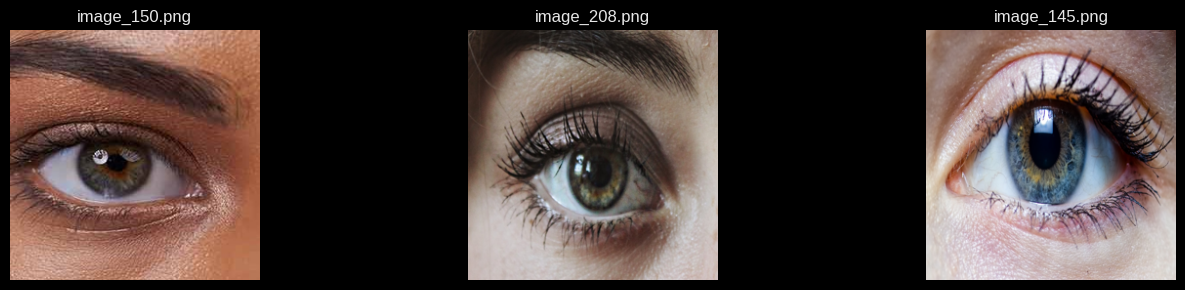

In [21]:
# Path name to visualize
visualize_path = '/kaggle/input/cataract-image-dataset/processed_images/train/normal/'

# Visualize random images
visualize_images(visualize_path, num_images=3)

## Visualize Cataract Eyes

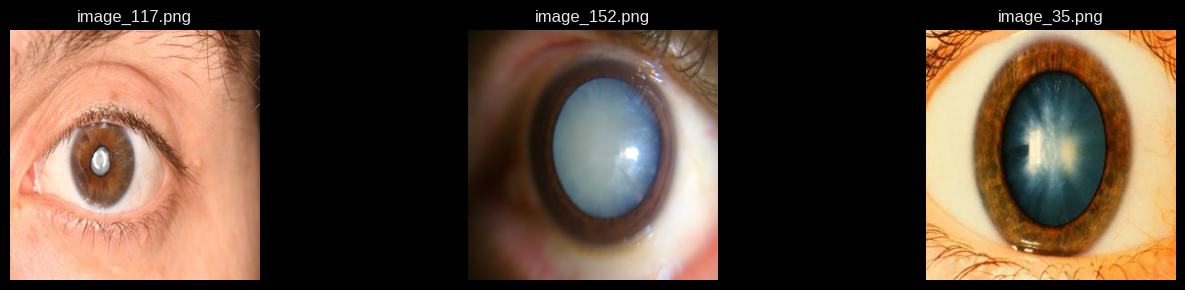

In [22]:
# Path name to visualize
visualize_path = '/kaggle/input/cataract-image-dataset/processed_images/train/cataract/'

# Visualize random images
visualize_images(visualize_path, num_images=3)

## Download a Pretrained Model - MobileNet V2

MobileNet V2 is a lightweight convolutional neural network (CNN) architecture, specifically designed for mobile and embedded vision applications. Google researchers developed it as an enhancement over the original MobileNet model. Another remarkable aspect of this model is its ability to strike a good balance between model size and accuracy, rendering it ideal for resource-constrained devices. 
Useful reading here: https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/

In [23]:
# Load a pretrained model
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 124MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### Preprocess the images

In [10]:
# Preprocessing for MobileNetV2
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])